### Patrick Horlaville (260931235) - Problem Set 4 - PHYS 641 : Observational Techniques in Modern Astrophysics

Prof: Jon Sievers. TA: Anan Lu

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import json
from scipy import signal

from simple_read_ligo import read_template
from simple_read_ligo import read_file

reading file  LOSC_Event_tutorial/H-H1_LOSC_4_V2-1126259446-32.hdf5


I adapted Jon's code to read in the data in my repository, which is at location:

In [2]:
loc = 'LOSC_Event_tutorial/'

## Problem 1

We would like to come up with a noise model for the Livingston and Hanford detectors

To window the data, we can use a Tukey window as recommended by the LOSC tutorial (https://github.com/losc-tutorial/LOSC_Event_tutorial/blob/master/LOSC_Event_tutorial.ipynb)

Using this tutorial as a guide towards unfolding the LIGO data, we can begin to familiarize ourselves with our dataset. First, we look into a particular event. Then, we can loop over all of them. We have 4 events:

In [3]:
fnjson = loc + 'BBH_events_v3.json'
events = json.load(open(fnjson, "r"))
for name in events:
    print(name)

GW150914
LVT151012
GW151226
GW170104


Let's look at:

In [25]:
name1 = 'GW150914'

In [26]:
event = events[name1]
fn_H1 = event['fn_H1']              
fn_L1 = event['fn_L1']              
fn_template = event['fn_template']  
fs = event['fs']                    
tevent = event['tevent']            
fband = event['fband']

In [27]:
strain_H1, dt_H1, utc_H1 = read_file(loc + fn_H1)
strain_L1, dt_L1, utc_L1 = read_file(loc + fn_L1)

In [72]:
tukey_wind = signal.tukey(n, alpha = 0.125)

In [73]:
wind_strain_H1 = strain_H1*tukey_wind
wind_strain_L1 = strain_L1*tukey_wind

In [74]:
Fk_H1 = np.abs(np.fft.rfft(wind_strain_H1))**2
Fk_L1 = np.abs(np.fft.rfft(wind_strain_L1))**2

In [37]:
fft_freqs = np.fft.rfftfreq(n, d = 1. / 4096.)

Text(0.5, 1.0, 'Unsmoothed Noise Hanford GW150914')

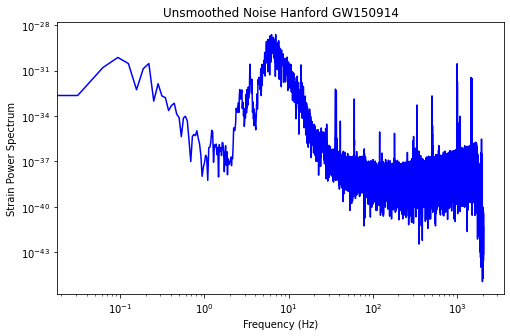

In [76]:
plt.figure(figsize = (8, 5))
plt.plot(fft_freqs, Fk_H1, color = 'b')
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Strain Power Spectrum")
plt.title("Unsmoothed Noise Hanford GW150914")

Text(0.5, 1.0, 'Unsmoothed Noise Livingston GW150914')

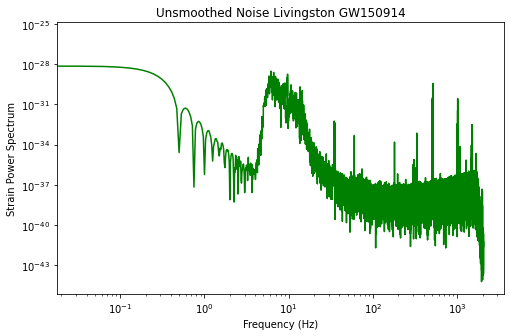

In [77]:
plt.figure(figsize = (8, 5))
plt.plot(fft_freqs, Fk_L1, color = 'g')
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Strain Power Spectrum")
plt.title("Unsmoothed Noise Livingston GW150914")

Now, we can produce the same quantities but average over all 4 events to have our model

In [32]:
all_noise_H1 = []
all_noise_L1 = []

In [33]:
n = len(strain_H1)
tukey_wind = signal.tukey(n, alpha = 0.125)

In [34]:
for name in events:

    event = events[name]
    fn_H1 = event['fn_H1']              
    fn_L1 = event['fn_L1']              
    fn_template = event['fn_template']  
    fs = event['fs']                    
    tevent = event['tevent']            
    fband = event['fband']
    
    strain_H1, dt_H1, utc_H1 = read_file('LOSC_Event_tutorial/' + fn_H1)
    strain_L1, dt_L1, utc_L1 = read_file('LOSC_Event_tutorial/' + fn_L1)
    
    wind_strain_H1 = strain_H1*tukey_wind
    wind_strain_L1 = strain_L1*tukey_wind
    
    Fk_H1 = np.abs(np.fft.rfft(wind_strain_H1))**2
    Fk_L1 = np.abs(np.fft.rfft(wind_strain_L1))**2
    
    all_noise_H1.append(Fk_H1)
    all_noise_L1.append(Fk_L1)

In [35]:
avg_noise_H1 = np.average(all_noise_H1, axis = 0)
avg_noise_L1 = np.average(all_noise_L1, axis = 0)

Text(0.5, 1.0, 'Hanford Noise Model [unsmoothed]')

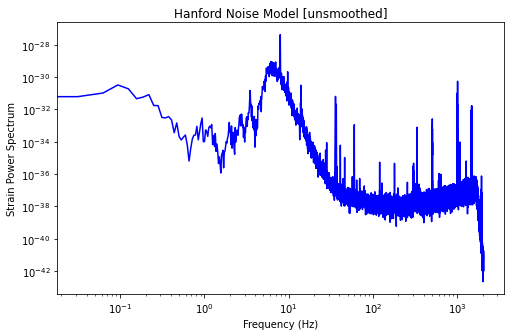

In [38]:
plt.figure(figsize = (8, 5))
plt.plot(fft_freqs, avg_noise_H1, color = 'b')
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Strain Power Spectrum")
plt.title('Hanford Noise Model [unsmoothed]')

Text(0.5, 1.0, 'Livingstone Noise Model [unsmoothed]')

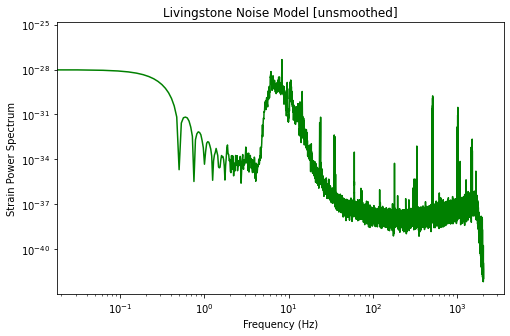

In [39]:
plt.figure(figsize = (8, 5))
plt.plot(fft_freqs, avg_noise_L1, color = 'g')
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Strain Power Spectrum")
plt.title('Livingstone Noise Model [unsmoothed]')

### Smoothing

To smooth our noise model, we can write a boxcar averaging function

In [40]:
def make_boxcar_kernel(n, width):
    boxcar = np.zeros(n)
    half_width = int(width / 2)
    boxcar[:half_width] = 1.
    boxcar[-half_width:] = 1.
    boxcar = boxcar / np.sum(boxcar)
    return boxcar

def smooth_noise(noise_estimate, n, width, kernel_type='gauss'):
    if kernel_type == 'boxcar':
        kern = make_boxcar_kernel(n, width)
    else:
        kern = make_gaussian_kernel(n, width)
    # Convolve the smoothing kernel with the noise estimate
    noise_estimateft = np.fft.rfft(noise_estimate)
    kernft = np.fft.rfft(kern)
    noise_estimate_smooth = np.fft.irfft(kernft * noise_estimateft, n)
    return noise_estimate_smooth

In [41]:
N_H1 = smooth_noise(avg_noise_H1, len(avg_noise_H1), 20, kernel_type='boxcar')
N_L1 = smooth_noise(avg_noise_L1, len(avg_noise_L1), 20, kernel_type='boxcar')

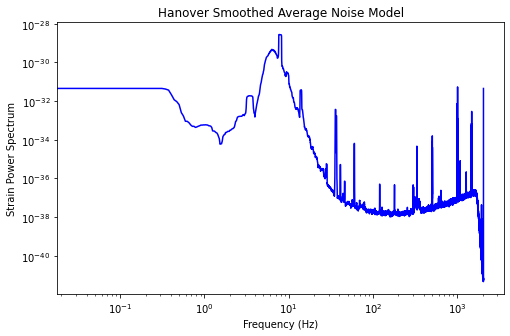

In [68]:
plt.figure(figsize = (8, 5))
plt.plot(fft_freqs, N_H1, color='b')
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Strain Power Spectrum")
plt.title("Hanover Smoothed Average Noise Model")
plt.savefig('noise_model_hanover.pdf')

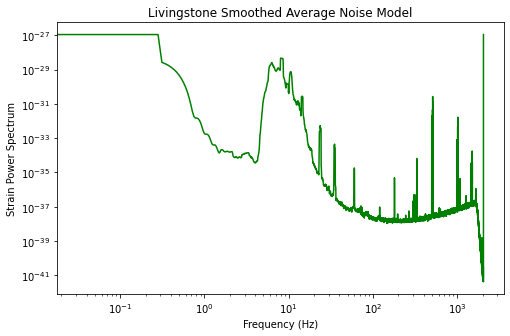

In [69]:
plt.figure(figsize = (8, 5))
plt.plot(fft_freqs, N_L1, color = 'g')
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Strain Power Spectrum")
plt.title("Livingstone Smoothed Average Noise Model")
plt.savefig('noise_model_livingstone.pdf')

I am not sure how to deal with the lines, so I will leave my noise model as that. We can also look at the noise spectrum [whose shape is just the reverse]:

### Noise spectra

In [42]:
Ninv_sqrt_H1 = 1 / np.sqrt(N_H1)
Ninv_sqrt_L1 = 1 / np.sqrt(N_L1)

Text(0.5, 1.0, 'Smoothed Average Noise Model Hanover')

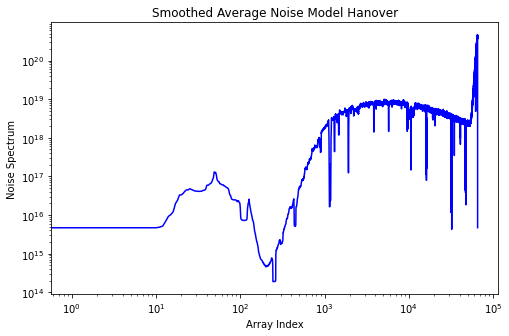

In [166]:
plt.figure(figsize = (8, 5))
plt.plot(np.arange(len(Ninv_sqrt_H1)), Ninv_sqrt_H1, color='b')
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Array Index")
plt.ylabel("Noise Spectrum")
plt.title("Smoothed Average Noise Model Hanover")

Text(0.5, 1.0, 'Smoothed Average Noise Model Livingstone')

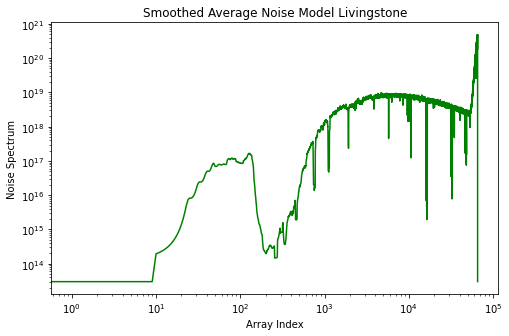

In [168]:
plt.figure(figsize = (8, 5))
plt.plot(np.arange(len(Ninv_sqrt_L1)), Ninv_sqrt_L1, color='g')
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Array Index")
plt.ylabel("Noise Spectrum")
plt.title("Smoothed Average Noise Model Livingstone")

### Matched filter & analytic SNR

We have to read the data and create the Tukey window (just as before). Now we calculate the whitened strain with the noise spectra, we load the template with Jon's function and we whiten it. With the whitened template and the whitened strain, we can find the matched filter. We can then divide by the whitened template to find the SNR. 

First, we plot the resulting SNR from the individual detectors

In [149]:
n = len(strain_H1)
tukey_wind = signal.tukey(n, alpha = 0.125)

In [207]:
snr_an_H1 = []
snr_an_L1 = []

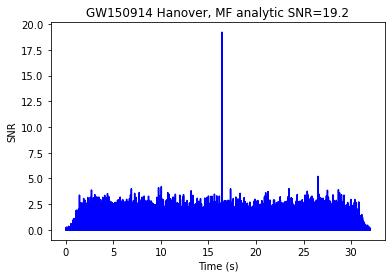

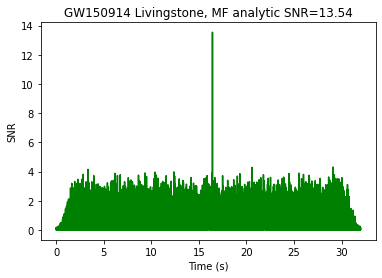

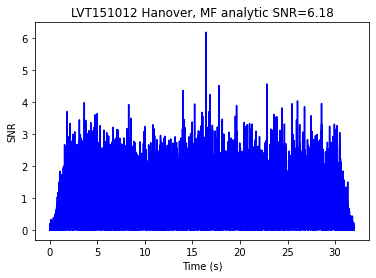

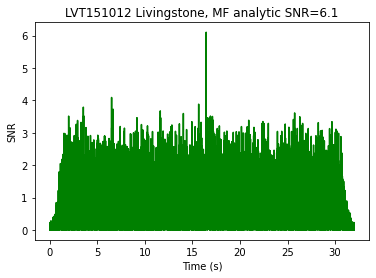

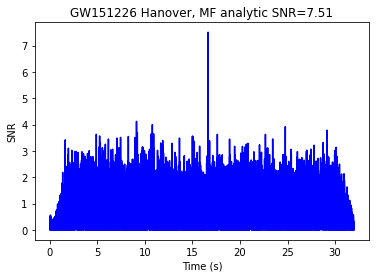

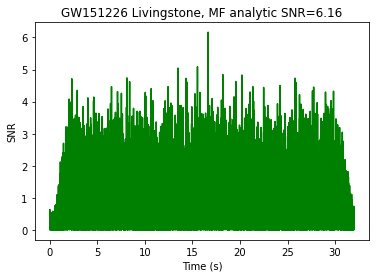

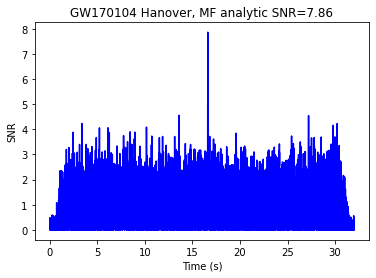

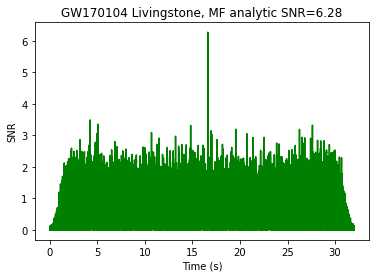

In [208]:
for i, name in enumerate(events):
    
    event = events[name]
    fn_H1 = event['fn_H1']              
    fn_L1 = event['fn_L1']              
    fn_template = event['fn_template']  
    fs = event['fs']                    
    tevent = event['tevent']            
    fband = event['fband']
    
    strain_H1, dt_H1, utc_H1 = read_file('LOSC_Event_tutorial/' + fn_H1)
    strain_L1, dt_L1, utc_L1 = read_file('LOSC_Event_tutorial/' + fn_L1)
    
    wind_strain_H1 = strain_H1*tukey_wind
    wind_strain_L1 = strain_L1*tukey_wind
    
    strainft_H1       = np.fft.rfft(wind_strain_H1)
    strainft_white_H1 = Ninv_sqrt_H1 * strainft_H1
    strain_white_H1   = np.fft.irfft(strainft_white_H1, n)
    strainft_L1       = np.fft.rfft(wind_strain_L1)
    strainft_white_L1 = Ninv_sqrt_L1 * strainft_L1
    strain_white_L1   = np.fft.irfft(strainft_white_L1, n)
    
    tl, template = read_template(loc + fn_template)
    
    templateft          = np.fft.rfft(template * tukey_wind)
    templateft_white_H1 = Ninv_sqrt_H1 * templateft
    template_white_H1   = np.fft.irfft(templateft_white_H1, len(template))
    templateft_white_L1 = Ninv_sqrt_L1 * templateft
    template_white_L1   = np.fft.irfft(templateft_white_L1, len(template))
    
    matched_filterft_H1  = strainft_white_H1 * np.conj(templateft_white_H1)
    matched_filter_H1    = np.fft.irfft(matched_filterft_H1, n)
    matched_filterft_L1  = strainft_white_L1 * np.conj(templateft_white_L1)
    matched_filter_L1    = np.fft.irfft(matched_filterft_L1, n)
    
    denom_H1 = np.mean(template_white_H1 * template_white_H1)
    snr_H1   = np.abs(matched_filter_H1 / np.sqrt(np.abs(denom_H1)))
    denom_L1 = np.mean(template_white_L1 * template_white_L1)
    snr_L1   = np.abs(matched_filter_L1 / np.sqrt(np.abs(denom_L1)))
    
    snr_an_H1.append(np.max(snr_H1))
    snr_an_L1.append(np.max(snr_L1))
    
    plt.figure(i)
    plt.plot(dt_H1 * np.arange(len(snr_H1)), np.roll(snr_H1, int(len(snr_H1)/2)), color='b')
    plt.xlabel('Time (s)')
    plt.ylabel('SNR')
    plt.title(name + ' Hanover, MF analytic SNR=' + str(round(np.max(snr_H1), 2)))
    
    plt.figure(i + 4)
    plt.plot(dt_L1 * np.arange(len(snr_L1)), np.roll(snr_L1, int(len(snr_L1)/2)), color='g')
    plt.xlabel("Time (s)")
    plt.ylabel("SNR")
    plt.title(name + " Livingstone, MF analytic SNR=" + str(round(np.max(snr_L1), 2)))

Second, we look at the combined SNR

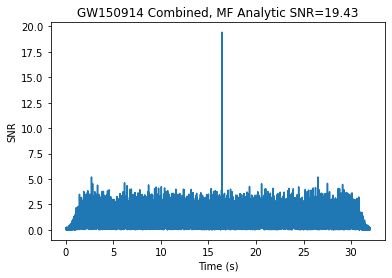

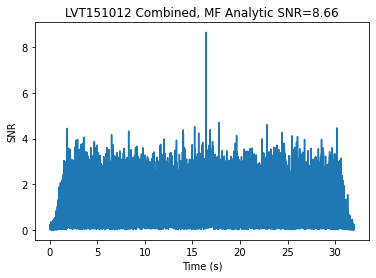

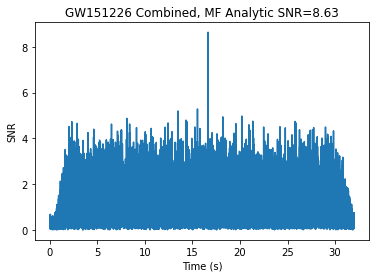

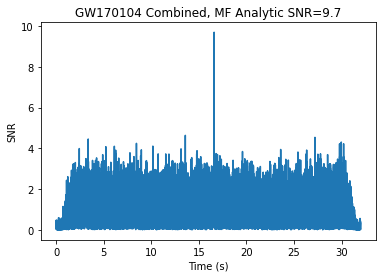

In [210]:
for i, name in enumerate(events):
    
    event = events[name]
    fn_H1 = event['fn_H1']              
    fn_L1 = event['fn_L1']              
    fn_template = event['fn_template']  
    fs = event['fs']                    
    tevent = event['tevent']            
    fband = event['fband']
    
    strain_H1, dt_H1, utc_H1 = read_file('LOSC_Event_tutorial/' + fn_H1)
    strain_L1, dt_L1, utc_L1 = read_file('LOSC_Event_tutorial/' + fn_L1)
    
    wind_strain_H1 = strain_H1*tukey_wind
    wind_strain_L1 = strain_L1*tukey_wind
    
    strainft_H1       = np.fft.rfft(wind_strain_H1)
    strainft_white_H1 = Ninv_sqrt_H1 * strainft_H1
    strain_white_H1   = np.fft.irfft(strainft_white_H1, n)
    strainft_L1       = np.fft.rfft(wind_strain_L1)
    strainft_white_L1 = Ninv_sqrt_L1 * strainft_L1
    strain_white_L1   = np.fft.irfft(strainft_white_L1, n)
    
    tl, template = read_template(loc + fn_template)
    
    templateft          = np.fft.rfft(template * tukey_wind)
    templateft_white_H1 = Ninv_sqrt_H1 * templateft
    template_white_H1   = np.fft.irfft(templateft_white_H1, len(template))
    templateft_white_L1 = Ninv_sqrt_L1 * templateft
    template_white_L1   = np.fft.irfft(templateft_white_L1, len(template))
    
    matched_filterft_H1  = strainft_white_H1 * np.conj(templateft_white_H1)
    matched_filter_H1    = np.fft.irfft(matched_filterft_H1, n)
    matched_filterft_L1  = strainft_white_L1 * np.conj(templateft_white_L1)
    matched_filter_L1    = np.fft.irfft(matched_filterft_L1, n)
    
    denom_H1 = np.mean(template_white_H1 * template_white_H1)
    snr_H1   = np.abs(matched_filter_H1 / np.sqrt(np.abs(denom_H1)))
    denom_L1 = np.mean(template_white_L1 * template_white_L1)
    snr_L1   = np.abs(matched_filter_L1 / np.sqrt(np.abs(denom_L1)))
    
    snr_comb = np.sqrt(snr_H1**2 + snr_L1**2)
    
    plt.figure(i)
    plt.plot(dt_H1 * np.arange(len(snr_comb)), np.roll(snr_comb, int(len(snr_comb)/2)))
    plt.xlabel("Time (s)")
    plt.ylabel("SNR")
    plt.title(name + " Combined, MF Analytic SNR=" + str(round(np.max(snr_comb), 2)))


### Scatter SNR

In [190]:
for i, name in enumerate(events):
    
    event = events[name]
    fn_H1 = event['fn_H1']              
    fn_L1 = event['fn_L1']              
    fn_template = event['fn_template']  
    fs = event['fs']                    
    tevent = event['tevent']            
    fband = event['fband']
    
    strain_H1, dt_H1, utc_H1 = read_file('LOSC_Event_tutorial/' + fn_H1)
    strain_L1, dt_L1, utc_L1 = read_file('LOSC_Event_tutorial/' + fn_L1)
    
    wind_strain_H1 = strain_H1*tukey_wind
    wind_strain_L1 = strain_L1*tukey_wind
    
    strainft_H1       = np.fft.rfft(wind_strain_H1)
    strainft_white_H1 = Ninv_sqrt_H1 * strainft_H1
    strain_white_H1   = np.fft.irfft(strainft_white_H1, n)
    strainft_L1       = np.fft.rfft(wind_strain_L1)
    strainft_white_L1 = Ninv_sqrt_L1 * strainft_L1
    strain_white_L1   = np.fft.irfft(strainft_white_L1, n)
    
    tl, template = read_template(loc + fn_template)
    
    templateft          = np.fft.rfft(template * tukey_wind)
    templateft_white_H1 = Ninv_sqrt_H1 * templateft
    template_white_H1   = np.fft.irfft(templateft_white_H1, len(template))
    templateft_white_L1 = Ninv_sqrt_L1 * templateft
    template_white_L1   = np.fft.irfft(templateft_white_L1, len(template))
    
    matched_filterft_H1  = strainft_white_H1 * np.conj(templateft_white_H1)
    matched_filter_H1    = np.fft.irfft(matched_filterft_H1, n)
    matched_filterft_L1  = strainft_white_L1 * np.conj(templateft_white_L1)
    matched_filter_L1    = np.fft.irfft(matched_filterft_L1, n)
    
    # Scatter SNR
    
    sigma_H1 = np.std(matched_filter_H1)
    sigma_L1 = np.std(matched_filter_L1)
    
    snr_sc_H1 = np.max(abs(matched_filter_H1))/sigma_H1
    snr_sc_L1 = np.max(abs(matched_filter_L1))/sigma_L1
    snr_sc_comb = np.sqrt(snr_sc_H1**2 + snr_sc_L1**2)
    
    # Analytic SNR
    
    denom_H1 = np.mean(template_white_H1 * template_white_H1)
    denom_L1 = np.mean(template_white_L1 * template_white_L1)
    
    snr_H1   = np.abs(matched_filter_H1 / np.sqrt(np.abs(denom_H1)))
    snr_L1   = np.abs(matched_filter_L1 / np.sqrt(np.abs(denom_L1)))
    snr_comb = np.sqrt(snr_H1**2 + snr_L1**2)
    
    print('event:', name)
    print('Analytic SNR (Hanover):', np.max(snr_H1))
    print('Analytic SNR (Livingstone):', np.max(snr_L1))
    print('Analytic combined SNR:', np.max(snr_comb))
    print('Scatter SNR (Hanover):', np.max(snr_sc_H1))
    print('Scatter SNR (Livingstone):', np.max(snr_sc_L1))
    print('Scatter combined SNR:', np.max(snr_sc_comb))
    print('\n')


event: GW150914
Analytic SNR (Hanover): 19.20192760634114
Analytic SNR (Livingstone): 13.541000663371454
Analytic combined SNR: 19.42966653180984
Scatter SNR (Hanover): 18.89963744340997
Scatter SNR (Livingstone): 12.781023143667362
Scatter combined SNR: 22.815583448408784


event: LVT151012
Analytic SNR (Hanover): 6.18316260389643
Analytic SNR (Livingstone): 6.1023078646918085
Analytic combined SNR: 8.6572094498105
Scatter SNR (Hanover): 6.23202171101755
Scatter SNR (Livingstone): 6.360289788670975
Scatter combined SNR: 8.90457078148444


event: GW151226
Analytic SNR (Hanover): 7.508162218190714
Analytic SNR (Livingstone): 6.161334131809967
Analytic combined SNR: 8.63165421370137
Scatter SNR (Hanover): 8.058421244248319
Scatter SNR (Livingstone): 5.277610530049528
Scatter combined SNR: 9.632825434764314


event: GW170104
Analytic SNR (Hanover): 7.858331386438519
Analytic SNR (Livingstone): 6.276537546660937
Analytic combined SNR: 9.699265420202536
Scatter SNR (Hanover): 7.600510770222

The SNR values, individual and combined, are fairly similar between the scatter and the analytic approach. They are expected to be different, as the noise model in both cases is built differently (for the analytic approach, we use the mean of a whitened template and for the scatter approach, we use the standard deviation of the signal)

### Frequency of half-weights

We would like to find the frequency from each event where half the weight comes from above that frequency and half below. To do so we can re-run our past processes as always, up until our white template. We can compute the power spectrum of this white template for both detectors and find its total power. Then, we compute the integrated power, frequency per frequency. If it reaches or surpasses half of the total power, the process stops and the current frequency is recorded.

In [203]:
halfweights_H1 = []
halfweights_L1 = []

In [216]:
for i, name in enumerate(events):
    
    event = events[name]
    fn_H1 = event['fn_H1']              
    fn_L1 = event['fn_L1']              
    fn_template = event['fn_template']  
    fs = event['fs']                    
    tevent = event['tevent']            
    fband = event['fband']
    
    strain_H1, dt_H1, utc_H1 = read_file('LOSC_Event_tutorial/' + fn_H1)
    strain_L1, dt_L1, utc_L1 = read_file('LOSC_Event_tutorial/' + fn_L1)
    
    wind_strain_H1 = strain_H1*tukey_wind
    wind_strain_L1 = strain_L1*tukey_wind
    
    strainft_H1       = np.fft.rfft(wind_strain_H1)
    strainft_white_H1 = Ninv_sqrt_H1 * strainft_H1
    strain_white_H1   = np.fft.irfft(strainft_white_H1, n)
    strainft_L1       = np.fft.rfft(wind_strain_L1)
    strainft_white_L1 = Ninv_sqrt_L1 * strainft_L1
    strain_white_L1   = np.fft.irfft(strainft_white_L1, n)
    
    tl, template = read_template(loc + fn_template)
    
    templateft          = np.fft.rfft(template * tukey_wind)
    templateft_white_H1 = Ninv_sqrt_H1 * templateft
    template_white_H1   = np.fft.irfft(templateft_white_H1, len(template))
    templateft_white_L1 = Ninv_sqrt_L1 * templateft
    template_white_L1   = np.fft.irfft(templateft_white_L1, len(template))
    
    matched_filterft_H1  = strainft_white_H1 * np.conj(templateft_white_H1)
    matched_filter_H1    = np.fft.irfft(matched_filterft_H1, n)
    matched_filterft_L1  = strainft_white_L1 * np.conj(templateft_white_L1)
    matched_filter_L1    = np.fft.irfft(matched_filterft_L1, n)
    
    ps_template_white_H1 = np.abs(templateft_white_H1)**2 / np.max(np.abs(templateft_white_H1)**2)
    total_power_H1 = np.sum(ps_template_white_H1)
    iter_sum_H1 = 0.
    for i in range(len(ps_template_white_H1)):
        iter_sum_H1 = iter_sum_H1 + ps_template_white_H1[i]
        if iter_sum_H1 >= total_power_H1 / 2.:
            halfweights_H1.append(fft_freqs[i])
            break
            
    ps_template_white_L1 = np.abs(templateft_white_L1)**2 / np.max(np.abs(templateft_white_L1)**2)
    total_power_L1 = np.sum(ps_template_white_L1)
    iter_sum_L1 = 0.
    for i in range(len(ps_template_white_L1)):
        iter_sum_L1 = iter_sum_L1 + ps_template_white_L1[i]
        if iter_sum_L1 >= total_power_L1 / 2.:
            halfweights_L1.append(fft_freqs[i])
            break

In [217]:
for i, name in enumerate(events):
    print('Event:', name)
    print('Hanover half power frequency:', halfweights_H1[i], 'Hz')
    print('Livingstone half power frequency:', halfweights_L1[i], 'Hz')
    print('\n')

Event: GW150914
Hanover half power frequency: 100.46875 Hz
Livingstone half power frequency: 117.9375 Hz


Event: LVT151012
Hanover half power frequency: 84.5625 Hz
Livingstone half power frequency: 99.09375 Hz


Event: GW151226
Hanover half power frequency: 84.6875 Hz
Livingstone half power frequency: 98.28125 Hz


Event: GW170104
Hanover half power frequency: 92.0 Hz
Livingstone half power frequency: 107.5625 Hz




### Arrival time uncertainty, and GW positions uncertainty

First, we pick out the arrival time at the match filter peak. Then, we look at how those times compare between the Hanover and Livingstone detectors. I noticed that for two events, it was of order ~ 0.001/0.1 s, and the two others are 0 s and ~1 s (odd). In any case, I will choose half of each time difference as the typical margin of error on the measurement of time to make things easier, even though it will output no error on the position of the event for which the time difference 0. The two detectors are approx. 3030.13km apart (https://astronomy.stackexchange.com/questions/13704/gravitational-wave-detection-time-difference-between-ligo-livingston-and-ligo-ha).

The geometric delay for the two detectors is:

$ct = b \rm{cos}(\theta)$

for $t$ the time difference between the arrivals, $\theta$ the baseline angle, $c$ the speed of light and $b$ the baseline between the two detectors. We know $c$, $t$ and $b$, and we would like to know the error on $\theta$, which should be:

$\Delta \theta = |\frac{d \theta}{dt}| \Delta t$

We have $\theta = arccos(\frac{ct}{b}$) so 

$\frac{d\theta}{dt} = -\frac{c}{b\sqrt{1 - \frac{c^2 t^2}{b^2}}}$

Hence, we have our formula for the error on $\theta$, the position on the sky of our event:

$\Delta \theta = \frac{c}{b\sqrt{1 - \frac{c^2 t^2}{b^2}}} \cdot \Delta t$

Reminder: I choose for $\Delta t$ half the value of $t$ to make things easier

In [44]:
time = np.arange(0, n)*dt_H1

In [70]:
for i, name in enumerate(events):
    
    event = events[name]
    fn_H1 = event['fn_H1']              
    fn_L1 = event['fn_L1']              
    fn_template = event['fn_template']  
    fs = event['fs']                    
    tevent = event['tevent']            
    fband = event['fband']
    
    strain_H1, dt_H1, utc_H1 = read_file('LOSC_Event_tutorial/' + fn_H1)
    strain_L1, dt_L1, utc_L1 = read_file('LOSC_Event_tutorial/' + fn_L1)
    
    wind_strain_H1 = strain_H1*tukey_wind
    wind_strain_L1 = strain_L1*tukey_wind
    
    strainft_H1       = np.fft.rfft(wind_strain_H1)
    strainft_white_H1 = Ninv_sqrt_H1 * strainft_H1
    strain_white_H1   = np.fft.irfft(strainft_white_H1, n)
    strainft_L1       = np.fft.rfft(wind_strain_L1)
    strainft_white_L1 = Ninv_sqrt_L1 * strainft_L1
    strain_white_L1   = np.fft.irfft(strainft_white_L1, n)
    
    tl, template = read_template(loc + fn_template)
    
    templateft          = np.fft.rfft(template * tukey_wind)
    templateft_white_H1 = Ninv_sqrt_H1 * templateft
    template_white_H1   = np.fft.irfft(templateft_white_H1, len(template))
    templateft_white_L1 = Ninv_sqrt_L1 * templateft
    template_white_L1   = np.fft.irfft(templateft_white_L1, len(template))
    
    matched_filterft_H1  = strainft_white_H1 * np.conj(templateft_white_H1)
    matched_filter_H1    = np.fft.irfft(matched_filterft_H1, n)
    matched_filterft_L1  = strainft_white_L1 * np.conj(templateft_white_L1)
    matched_filter_L1    = np.fft.irfft(matched_filterft_L1, n)
    
    H1_time = time[np.argmax(matched_filter_H1)]
    L1_time = time[np.argmax(matched_filter_L1)]
    t = abs(H1_time - L1_time)
    
    delta_t = t/2
    b = 3030.130 * 1000 # baseline, in m
    c = 3e8 # speed of light
    
    delta_theta = (c*delta_t/(b*np.sqrt(1 - (c*t/b)**2)))
    
    print('Event:', name)
    print('Hanover arrival time:', H1_time, 's')
    print('Livingstone arrival time:', L1_time, 's')
    print('Time difference:', t, '(+/-)', t/2, 's')
    print('Error on GW event position:', round(delta_theta, 2), 'rad, or', round(delta_theta*180/np.pi, 2), 'degrees')
    print('\n')

<ipython-input-70-59c4075bb14d>:45: RuntimeWarning: invalid value encountered in sqrt
  delta_theta = (c*delta_t/(b*np.sqrt(1 - (c*t/b)**2)))


Event: GW150914
Hanover arrival time: 0.442138671875 s
Livingstone arrival time: 0.431396484375 s
Time difference: 0.0107421875 (+/-) 0.00537109375 s
Error on GW event position: nan rad, or nan degrees


Event: LVT151012
Hanover arrival time: 1.798583984375 s
Livingstone arrival time: 0.443359375 s
Time difference: 1.355224609375 (+/-) 0.6776123046875 s
Error on GW event position: nan rad, or nan degrees


Event: GW151226
Hanover arrival time: 0.645263671875 s
Livingstone arrival time: 0.648193359375 s
Time difference: 0.0029296875 (+/-) 0.00146484375 s
Error on GW event position: 0.15 rad, or 8.68 degrees


Event: GW170104
Hanover arrival time: 0.609619140625 s
Livingstone arrival time: 0.609619140625 s
Time difference: 0.0 (+/-) 0.0 s
Error on GW event position: 0.0 rad, or 0.0 degrees




For the third event, the angular uncertainty in the sky of the GW is of ~ 9 degrees. For the rest, the time differences values are either too big (1 s for LVT151012 is suspiciously big) or erroneous (0 s for GW170104 is unphysical). According to what I've done, a time difference superior to about 0.01 yields a negative square root, which would suggest that time differences above that threshold are unphysical. Then why are 2 time differences superior to that? Maybe I have misimplemented something (which would explain the 0 s delay for the GW170104 event, which is definitely not what I would have expected) but I can't find what. Maybe my error derivation is wrong too; maybe that half the time difference as the error is not reasonable for some time values.

## Problem 2

We would like to maximize the signal of our feed. To do so, we would like to maximize the gain at our feed, which is proportional to the effective area of our dish $A_{\rm{eff}}$ per the total area of the dish $A$. This is another way of saying: the more the area of our dish is used to collect the signal, the stronger the signal. If our parameter is the width of the feed's beam $\sigma$, then increasing $\sigma$ will increase the portion of the primary signal used. Although, as pointed out by the problem statement, we have to consider "leakage" of the signal: as $\sigma$ increases, some of the signal leaves the dish for the ground, which reduces the signal strength. The question is then: what $\sigma$ maximizes the signal strength?

We have a Gaussian beam pattern, so the feed gain pattern $G(r, \sigma)$ should look like:

$G(r, \sigma) = e^{-\frac{r^2}{2\sigma^2}}$

The effective area is the integrated gain over the surface of our dish, so we take:

$A_{\rm{eff}} = \int_0 ^R G(r, \sigma) 2 \pi r dr$

The total area of our dish is just:

$A = \int_0 ^R 2 \pi r dr$

Let's denote the "un-leaked" fraction of the signal by $f_s$. Then, the strength of our signal $S$ is:

$S = f_s \frac{A_{\rm{eff}}}{A}$

What is $f_s$? It is the fraction of the signal that has stayed on our dish. It can also be seen as the fraction of the area of the total beam that has reached our dish; so $f_s = \frac{A_{\rm{eff}}}{A_{\rm{tot}}}$ for $A_{\rm{tot}}$ the total area of the beam. $A_{\rm{tot}}$ is the gain beam integrated over all space:

$A_{\rm{tot}} = \int_0 ^\infty G(r, \sigma) 2 \pi r dr$

So we now know how to find the strength of our signal as a function of $\sigma$. If we simplify the expression, it boils down to:

$S = \frac{A_{\rm{eff}}}{A_{\rm{tot}}} \frac{A_{\rm{eff}}}{A} = \frac{A_{\rm{eff}}^2}{\pi R^2 A_{\rm{tot}}}$

Let's try numerically and see if we can optimize for specific values of $\sigma$:

In [73]:
import scipy.integrate as integrate

In [95]:
def G(r, sig):
    return np.exp(-(r**2)/(2*(sig**2)))

def A(R):
    return np.pi*(R**2)

def int_arg(r, sig):
    return G(r, sig)*2*np.pi*r

def A_eff(R, r, sig):
    return (integrate.quad(int_arg, 0, R, sig))[0]

def A_tot(R, r, sig):
    return (integrate.quad(int_arg, 0, np.inf, sig))[0]

In [97]:
R_t = 1 #m
r_t = np.linspace(0, R, 100)
sigma = np.linspace(0.01, 5, 100)
S = [0 for i in range(len(sigma))]

In [101]:
for i in range(len(sigma)):
    S[i] = ((A_eff(R_t, r_t, sigma[i]))**2)/(A_tot(R_t, r_t, sigma[i]) * np.pi * (R_t**2))

Text(0, 0.5, 'Signal strength')

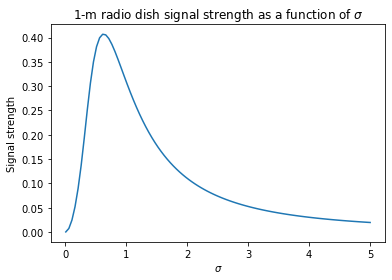

In [104]:
plt.plot(sigma, S)
plt.title(r'1-m radio dish signal strength as a function of $\sigma$')
plt.xlabel(r'$\sigma$')
plt.ylabel('Signal strength')

In [114]:
Aeff_A = (A_eff(R_t, r_t, sigma[np.argmax(S)]))/(np.pi * R_t**2)
Aeff_Atot = (A_eff(R_t, r_t, sigma[np.argmax(S)]))/(A_tot(R_t, r_t, sigma[np.argmax(S)]))

In [132]:
print('The signal strength peak value is', round(S[np.argmax(S)], 3), ', which is attained at 𝜎 =', round(sigma[np.argmax(S)], 3), '.')
print('At this 𝜎,', round(100*Aeff_A), '% of the dish area is effective and', round(100*Aeff_Atot), '% of the total beam is captured.')

The signal strength peak value is 0.407 , which is attained at 𝜎 = 0.615 .
At this 𝜎, 55 % of the dish area is effective and 73 % of the total beam is captured.
